In [170]:
from torchvision import transforms, datasets
import os
import glob
from random import shuffle
import torch
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
import scipy.io as scio
from func import basic,visualization
import numpy as np
import pandas as pd


# 以5x做单折测试

## 分配数据集

In [171]:
data_5x = glob.glob('/mnt/wangyh/CN_patches/*/*/5X/T*')
# set of 5x tumor tiles, has a length of 28277

In [21]:
# 5折交叉
size_val = len(data_5x)//5
# size_train = len(data_5x)- size_val

shuffle(data_5x)
val = data_5x[:size_val]
train = data_5x[size_val:]

In [ ]:
IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm']

In [77]:
def myData(args):
# data_transform, pay attention that the input of Normalize() is Tensor and the input of RandomResizedCrop() or RandomHorizontalFlip() is PIL Image
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    image_datasets = {}
    #image_datasets['train'] = datasets.ImageFolder(os.path.join(args.data_dir, 'ILSVRC2012_img_train'), data_transforms['train'])

    image_datasets['train'] = myDataSet(train,data_transforms=data_transforms['train'])
    image_datasets['val'] = myDataSet(val,data_transforms=data_transforms['val'])

    # wrap your data and label into Tensor
    dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                 batch_size=args.batch_size,
                                                 shuffle=True,
                                                 num_workers=args.num_workers) for x in ['train', 'val']}


    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    return dataloders, dataset_sizes

class myDataSet(torch.utils.data.Dataset):
    def __init__(self, img_list,data_transforms = None):
        label_dic = {
            'H':0,
            'L':1
        }
        self.img_list = img_list
        self.label_dic = label_dic
        self.data_transforms = data_transforms
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        label_dic = {
            'H':0,
            'L':1
        }
        item = self.img_list[index]
        img = Image.open(item)
        if self.data_transforms is not None:
            try:
                img = self.data_transforms(img)
            except:
                print("Cannot transform image: {}".format(self.img_list[index]))
        label = label_dic[Path(item).parts[4]]
        return img, label

# 对5x数据集，resnext表现评估

In [89]:
loss = np.load("./resnext/output/lossdata.npy",allow_pickle= True).item()

In [94]:
acc = np.load('./resnext/output/accdata.npy',allow_pickle=True).item()

In [121]:
df_loss = pd.DataFrame(loss)

In [ ]:
for x in ['train','val']:
    acc[x] = [i.cpu() for i in acc[x]]

In [115]:
df_acc = pd.DataFrame(acc)

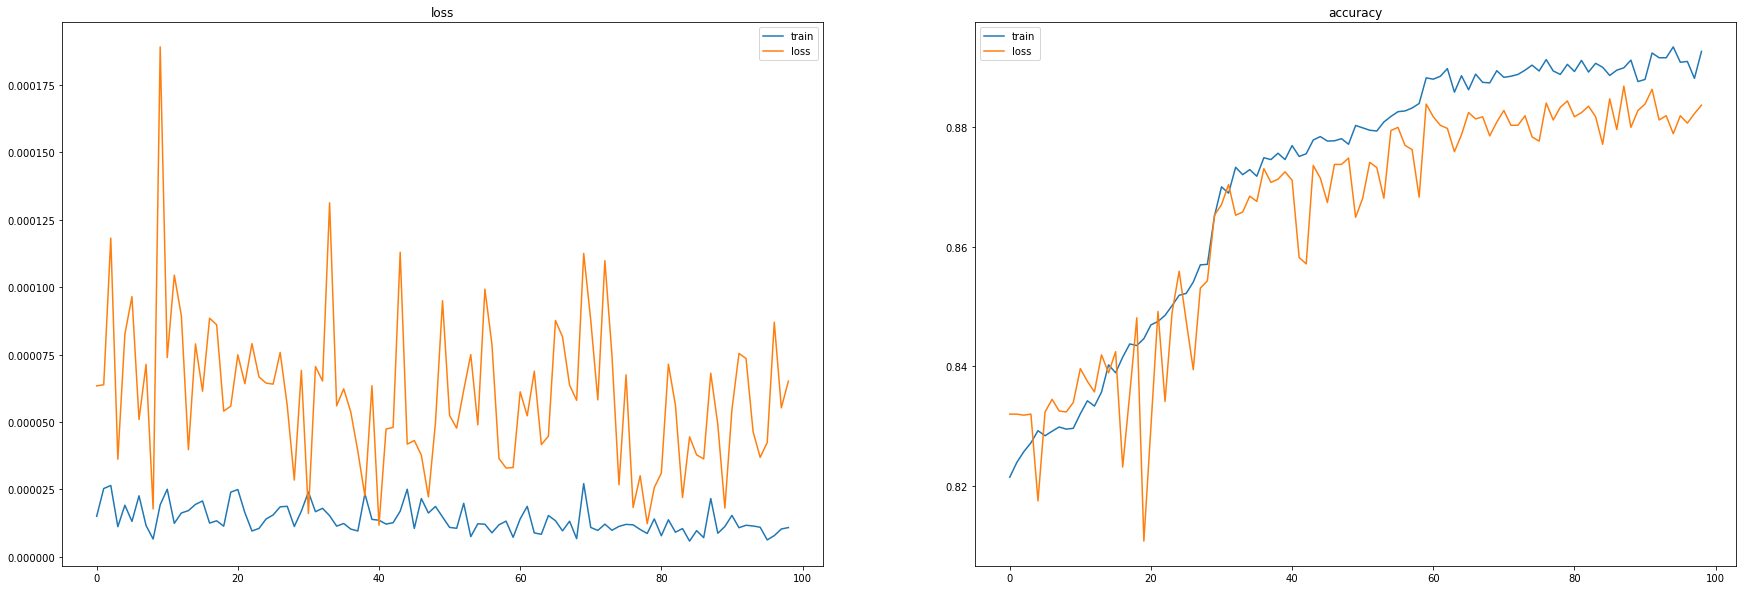

In [130]:
fig,axes = plt.subplots(1,2,figsize = (30,10))
ax1 = axes[0]
ax1.set_title('loss')
ax1.plot(df_loss['train'],label = 'train')
ax1.plot(df_loss['val'],label = 'loss')
ax1.legend()


ax2 = axes[1]
ax2.set_title('accuracy')
ax2.plot(df_acc['train'],label = 'train')
ax2.plot(df_acc['val'],label = 'loss')
ax2.legend()

# 用内部数据自己做一下验证

在resnext文件夹里面进行验证，不在该文件夹会报namespace错误：

AttributeError: Can't get attribute 'ResNeXt' on <module 'resnext' (namespace)>